In [1]:
# Reference
# https://yurimkoo.github.io/python/2019/09/14/connect-db-with-python.html

from dotenv import load_dotenv
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from functions.pubgapi import get_tournament_info
from functions.pubgapi import get_match_info
from functions.pubgapi import get_match_participant_single
from functions.pubgapi import standard_scaling
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Load api key & RDS info (endpoint="rds 엔드포인트", dbname="db 이름", username="마스터 사용자 이름", password="rds 비밀번호")
load_dotenv()
api_key = os.environ.get("API_KEY")
endpoint = os.environ.get("AWS_endpoint")
dbname = os.environ.get('AWS_dbname')
username = os.environ.get("AWS_username")
password = os.environ.get("AWS_password")

In [2]:
# 결측치 확인 함수
def check_missing_value(filename, df):
    # 결측치가 발생한 부분에서 log 파일(.csv) 생성
    if (df.isnull().sum()).sum() != 0:
        data.to_csv(f"./Data/Error_log/{filename}.csv")
        raise Exception(f"Missing value: {(df.isnull().sum()).sum()}\nError_log: pubg_api/Data/Error_log/{filename}.csv")

In [3]:
# tournament_info 불러오기
tournament_info = get_tournament_info(api_key)
check_missing_value('tournament_info', tournament_info)

for tournament_index in range(8,17): #len(tournament_info["id"])
    # index 설정 및 해당 인덱스의 tournament_id 값 불러오기
    tournament_name = tournament_info["id"][tournament_index]
    tournament_createdAt = tournament_info["createdAt"][tournament_index]

    # cur_match_info(Current match info) 불러오기
    cur_match_info = get_match_info(api_key, tournament_name)

    # match_participant_single 불러오기
    for match_index in range(len(cur_match_info["matchId"])):
        match_participant_single = get_match_participant_single(api_key, cur_match_info["matchId"][match_index])
        check_missing_value(cur_match_info["matchId"][match_index], match_participant_single)

        # Z-score normalization 수행
        # data = z_normalization(match_participant_single)
        data = match_participant_single

        if os.path.isfile("./Data/Train_data/train_match_data.csv"):
            # 해당 경로에 train_match_data.csv 파일이 있으면, 현재 내용을 해당 파일에 추가
            train_data = pd.read_csv(f"./Data/Train_data/train_match_data.csv")
            train_data.drop(["Unnamed: 0"], axis = 1, inplace = True)
            train_data = pd.concat([train_data, data], ignore_index=True)
            train_data.to_csv(f"./Data/Train_data/train_match_data.csv")
        else:
            # 해당 경로에 train_match_data.csv 파일이 없으면, 파일 생성
            data.to_csv(f"./Data/Train_data/train_match_data.csv")

In [4]:
data = pd.read_csv(f"./Data/Train_data/train_match_data.csv")
data.drop(["Unnamed: 0", "match_id", "player_id"], axis = 1, inplace = True)

In [5]:
# VIF

z_label = (["dbnos", "assists", "boosts", "damage_dealt", "heals", "kill_streaks", "kills", "longest_kill", "revives", "ride_distance", "swim_distance", "headshot_kills", "vehicle_destroys", "walk_distance", "weapons_acquired"])
data_corr = data[z_label]

vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["VIF Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

,features,VIF Factor
0,dbnos,5.339083
1,assists,1.871511
2,boosts,5.092986
3,damage_dealt,7.006060
4,heals,2.367205
5,kill_streaks,6.149492
6,kills,9.311190
7,longest_kill,2.046108
8,revives,1.336545
9,ride_distance,3.200433


<AxesSubplot:>

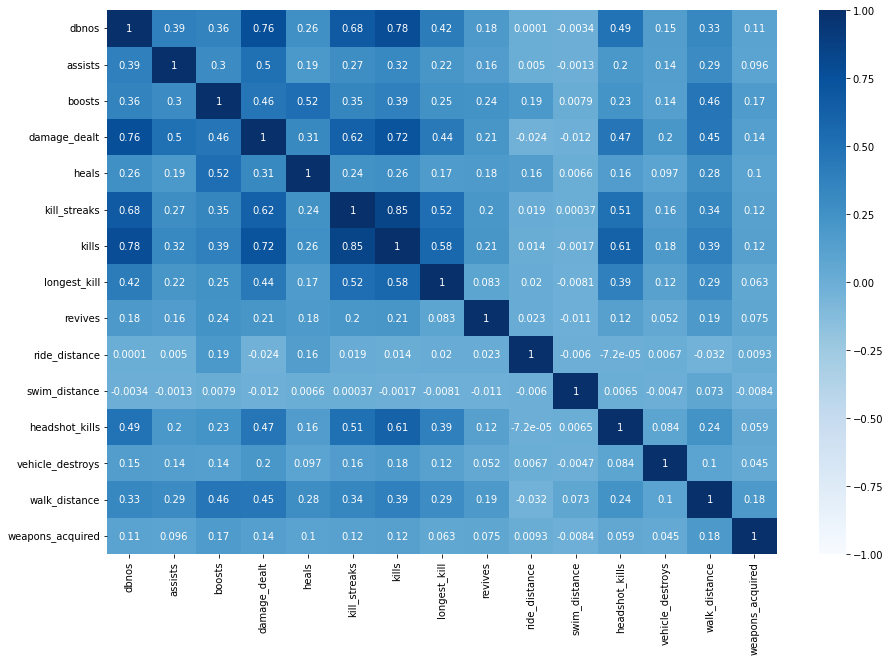

In [6]:
# https://tjansry354.tistory.com/13

plt.rcParams['figure.figsize']=(15,10)
sb.heatmap(data_corr.corr(), annot=True, cmap='Blues', vmin = -1, vmax = 1)

<AxesSubplot:>

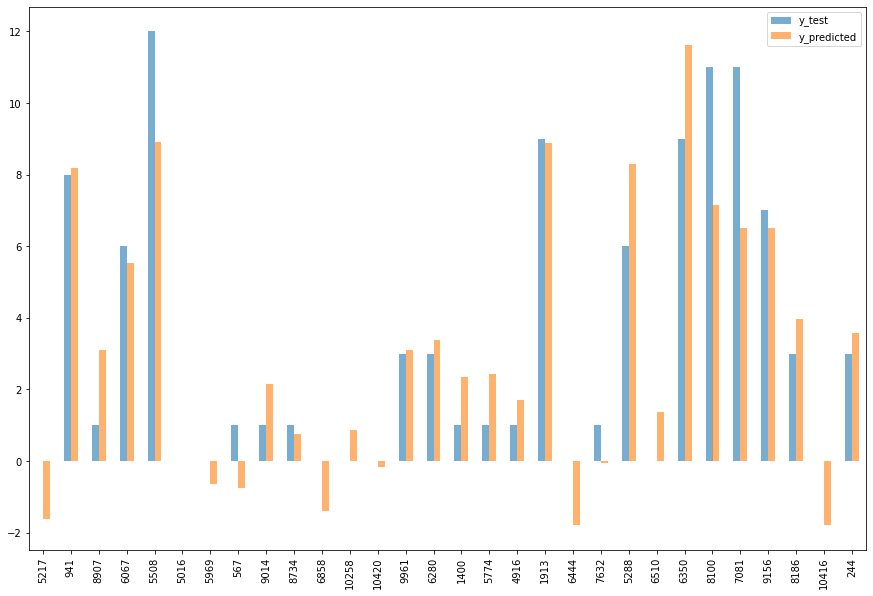

In [7]:
# linear regression -> round_point 획득량 예상 -> mvp 지표로 사용 가능
# https://tjansry354.tistory.com/12?category=927195

# 학습 데이터와 테스트 데이터로 분리합니다.
# '선수명', 'y'를 제외한 칼럼들은 X
X = data[data.columns.difference(['round_point', 'win'])]
y = data['round_point']

# 검증(test)는 20%로 한다
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# 회귀 분석 객체 생성(선형 회귀 모델 생성)
lr = linear_model.LinearRegression()

# fit()는 기울기와 절편을 전달하기 위함.
model = lr.fit(X_train, y_train)

# 학습된 계수를 출력합니다.
# print(lr.coef_)

# 상수항을 출력합니다.
# print(lr.intercept_)

x_new=X_test
y_new=model.predict(x_new)

# y_compare={'round_point_test':y_test, 'round_point_predicted':y_new}
y_compare={'y_test':y_test, 'y_predicted':y_new}

pd.DataFrame(y_compare)[:30].plot(y=['y_test', 'y_predicted'], alpha=0.6, kind="bar")

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.936


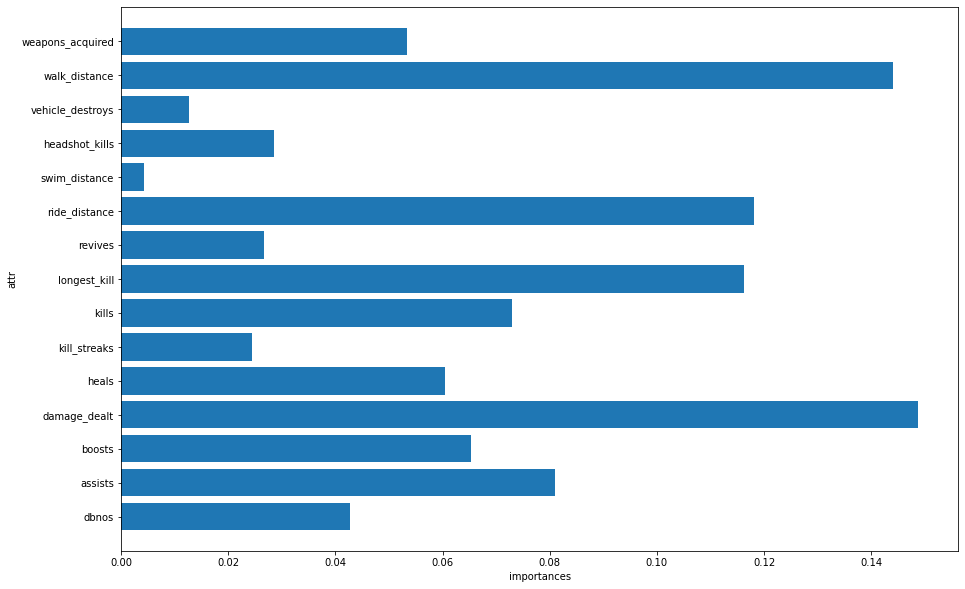

In [8]:
# Random Forest -> 우승 예측
data = standard_scaling(data)
z_label = (["dbnos", "assists", "boosts", "damage_dealt", "heals", "kill_streaks", "kills", "longest_kill", "revives", "ride_distance", "swim_distance", "headshot_kills", "vehicle_destroys", "walk_distance", "weapons_acquired"])
X = data[z_label]
y = data["win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

forest = RandomForestClassifier(n_estimators=50, random_state=0)
forest.fit(X_train,y_train)

print("훈련 세트 정확도 : {:.3f}".format(forest.score(X_train,y_train)))
print("테스트 세트 정확도 : {:.3f}".format(forest.score(X_test,y_test)))

# 특성 중요도 시각화 하기
def plot_feature_importances(model):
    n_features = len(z_label)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), z_label)
    plt.xlabel("importances")
    plt.ylabel("attr")
    plt.ylim(-1, n_features)
plt.show()

plot_feature_importances(forest)

In [9]:
mvp_feature = (forest.feature_importances_)*data[z_label]
data["win_feature"] = mvp_feature.sum(axis=1)

data[['round_point','win','win_feature']].sort_values(["win_feature"], ascending=False)[:30]

,round_point,win,win_feature
4739,5,0,2.705484
7015,13,0,2.385771
4811,10,0,2.361823
5842,15,1,2.361218
2066,11,0,2.276109
5844,14,1,2.241408
8544,17,1,2.234887
8877,15,1,2.222812
7577,11,0,2.214717
2304,9,0,2.206345
